### Decode 3D hand movements from spiking data

##### Summary of data
I use spiking data from 175 neurons to predict hand movements in 3D dimensions.
1. Neural Data: recorded from a Utah Array implanted in sensorimotor cortex of a common marmoset. Spike counts are binned in 20ms windows.
2. Kinematic Data: 3D hand position, which was estimated from video data using DeepLabCut. 
3. Experimental Behavior: the marmoset is capturing live moths in a prey-capture box. 

##### Summary of models
I implement an LSTM model to predict instananeous position of the hand in 3D from spike count data in 175 neurons. I define a sequence length and decoder lead time such that the specified time bins of neural activity predict movement a short time later (50ms). 

I started with a relatively simple LSTM model:
1. Hidden layers: 1
2. Units in hidden layer: 32
3. Dropout: 0.0
4. Weight decay: 0
5. Momentum: 0
6. lr = 0.001 (SGD)
7.  

In [290]:
import torch
from torch import nn

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
from itertools import product
from tqdm import trange
from pathlib import Path

data_path = Path('../data')
h5_datafile = data_path / 'movement_data.h5' 

bin_ms = 20 
sequence_time_ms = 150
decoder_lead_time_ms = 50
sequence_bins = int(sequence_time_ms / bin_ms) 
decoder_lead_bins = int(decoder_lead_time_ms / bin_ms)

In [292]:
reach_pos_and_spikes = pd.read_hdf(h5_datafile, f'reach_pos_and_spikes_{bin_ms}ms_bins')

spikes_train_val, spikes_test, pos_train_val, pos_test = train_test_split(reach_pos_and_spikes['spikes'], reach_pos_and_spikes['position'], test_size=0.20, random_state=42,shuffle=True)
spikes_train, spikes_val, pos_train, pos_val           = train_test_split(spikes_train_val, pos_train_val, test_size=0.20, random_state=43,shuffle=True)

num_neurons = reach_pos_and_spikes.loc[0, 'spikes'].shape[0]
spikes_t0_bin = reach_pos_and_spikes.loc[0, 'spikes'].shape[1] - reach_pos_and_spikes.loc[0, 'position'].shape[1] 

In [293]:
def prepare_single_trial_data(trial_spikes, trial_position, sequence_bins, decoder_lead_bins, spikes_t0_bin, device):
    spikes_list   = []
    position_list = []
    
    for pos_bin in range(trial_position.shape[-1]):
        
        if np.all(np.isnan(trial_position[0, pos_bin:])):
            break
        
        spikes_bin = pos_bin + spikes_t0_bin
        tmp_spks = trial_spikes[:, spikes_bin - sequence_bins - decoder_lead_bins : spikes_bin - decoder_lead_bins +1]
        tmp_spks = tmp_spks.T

        tmp_pos  = trial_position[:, pos_bin]

        spikes_list.append(  torch.tensor(tmp_spks, dtype=torch.float32).to(device))
        position_list.append(torch.tensor(tmp_pos , dtype=torch.float32).to(device))    

    return spikes_list, position_list

In [294]:
def plot_pred_vs_true_pos(position_pred, position_true, trial_r2, data_group, reach_num):
    fig, ax = plt.subplots()
    ax.plot(position_true[0] + 20, '-k', label='x')
    ax.plot(position_pred[0] + 20, '-.k', label='Predicted x')
    ax.plot(position_true[1], '-b', label='y')
    ax.plot(position_pred[1], '-.b', label='Predicted y')
    ax.plot(position_true[2] - 5, '-g', label='z')
    ax.plot(position_pred[2] - 5, '-.g', label='Predicted z')
    ax.set_title(f'{data_group} set, reach number {reach_num}, r2 = {trial_r2:.2f}')
    ax.legend()
    plt.show()


In [295]:
def predict_single_trial_position(model, eval_dict, sequence_bins, decoder_lead_bins, spikes_t0_bin, device, plot=False):

    spks_arr = eval_dict['spikes'].iloc[eval_dict['idx']]
    pos_arr  = eval_dict['position'].iloc[eval_dict['idx']]
    data_group = eval_dict['group']
    reach_num = eval_dict['spikes'].index[eval_dict['idx']]

    model.eval()
    with torch.inference_mode():
        spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               sequence_bins=sequence_bins,
                                                               decoder_lead_bins=decoder_lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)
        
        position_pred = np.full_like(pos_arr, np.nan)
        for bin, (spks, pos) in enumerate(zip(spikes_list, position_list)):
            pos_out_tensor = model(spks)
            position_pred[:, bin] = pos_out_tensor.cpu().numpy()

        good_idxs = np.where(~np.isnan(pos_arr.flatten()))[0] 
        trial_r2 = r2_score(pos_arr.flatten()[good_idxs], position_pred.flatten()[good_idxs])

        if plot:
            plot_pred_vs_true_pos(position_pred, pos_arr, trial_r2, data_group, reach_num)

    return trial_r2

In [296]:
def test_set_performance(model, spikes_test, pos_test, sequence_bins, decoder_lead_bins, spikes_t0_bin, device, plot=True):
    all_trials_r2 = np.full((spikes_test.shape[0],), np.nan)   
    nsamples_arr = np.full_like(all_trials_r2, np.nan)
    for idx in range(spikes_test.shape[0]): 
        eval_dict = dict(group='test', idx=idx, spikes=spikes_test, position=pos_test)
        trial_r2 = predict_single_trial_position(model, 
                                                eval_dict, 
                                                sequence_bins, 
                                                decoder_lead_bins,
                                                spikes_t0_bin, 
                                                device, 
                                                plot=plot)

        all_trials_r2[idx] = trial_r2 
        nsamples_arr[idx]  = (~np.isnan(pos_test.iloc[idx])).sum()

    combined_r2 = (all_trials_r2 * nsamples_arr).sum() / nsamples_arr.sum()

    return combined_r2

In [297]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [298]:
class LSTM_position_decoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super(LSTM_position_decoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size  = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers  = num_layers,  
                            dropout     = dropout)

        # The linear layer that maps from hidden state space to 3D position
        self.hidden2pos = nn.Linear(hidden_dim, 3, device=device)

    def forward(self, spikes):
        lstm_out, _  = self.lstm(spikes)
        position_out = self.hidden2pos(lstm_out[-1])
        return position_out

In [308]:
lstm_model = LSTM_position_decoder(input_dim  = num_neurons, 
                                   hidden_dim = 64,
                                   num_layers = 2,
                                   dropout    = 0.4).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.7)

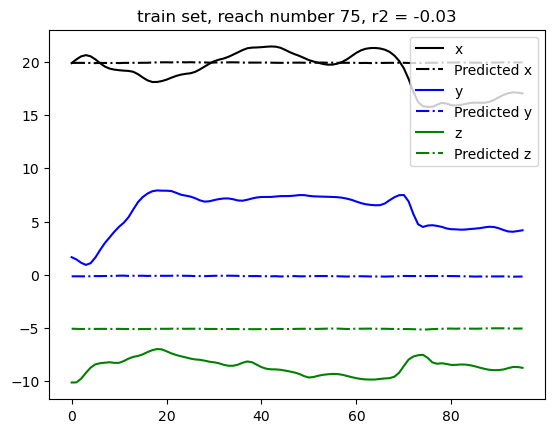

In [309]:

eval_dict = dict(group='train', idx=0, spikes=spikes_train, position=pos_train)
trial_r2 = predict_single_trial_position(lstm_model, 
                                         eval_dict, 
                                         sequence_bins, 
                                         decoder_lead_bins,
                                         spikes_t0_bin, 
                                         device, 
                                         plot=True)

In [310]:
def train_model(model, spikes_train, pos_train, spikes_val, pos_val, 
                sequence_bins, decoder_lead_bins, spikes_t0_bin, device,
                loss_function, optimizer, epochs=5, print_res=True):
    
    tloss = [[] for e in range(epochs)] 
    vloss = [[] for e in range(epochs)] 
    for epoch in range(epochs): 
        #-----------------------------------------------------------------------
        # Training Step
        #-----------------------------------------------------------------------
        model.train()

        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        for trial, (spks_arr, pos_arr) in enumerate(zip(spikes_train.values, pos_train.values)):

            spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               sequence_bins=sequence_bins,
                                                               decoder_lead_bins=decoder_lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)

            for bin, (spks, position_true) in enumerate(zip(spikes_list, position_list)):
                # print(f'epoch = {epoch}, trial = {trial}, bin = {bin}')
                
                if position_true.isnan().sum() > 0:
                     continue
                
                # if trial == 3 and bin == 1:
                #      catchhere = []

                optimizer.zero_grad()
                position_pred = model(spks)

                if position_pred.isnan().sum() > 0:
                     return

                loss = loss_function(position_pred, position_true)
                loss.backward()
                optimizer.step()

                tloss[epoch].append(loss.item())
                y_true_train.extend(list(position_true.cpu().data.numpy().flatten()))
                y_pred_train.extend(list(position_pred.cpu().data.numpy().flatten()))
                total_loss_train += loss.item()

        train_loss = total_loss_train/(spikes_train.shape[0] * len(spikes_list)) 
        train_r2 = r2_score(y_true_train, y_pred_train) 

        #-----------------------------------------------------------------------
        # Validation Step
        #-----------------------------------------------------------------------
        model.eval()
        y_true_val = list()
        y_pred_val = list()
        total_loss_val = 0

        for spks_arr, pos_arr in zip(spikes_val.values, pos_val.values):
            spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               sequence_bins=sequence_bins,
                                                               decoder_lead_bins=decoder_lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)
            for bin, (spks, position_true) in enumerate(zip(spikes_list, position_list)):
                if position_true.isnan().sum() > 0:
                     continue
                position_pred = model(spks)
                loss = loss_function(position_pred, position_true)

                vloss[epoch].append(loss.item())
                y_true_val.extend(list(position_true.cpu().data.numpy().flatten()))
                y_pred_val.extend(list(position_pred.cpu().data.numpy().flatten()))
                total_loss_val += loss.item()

        val_loss = total_loss_val/(spikes_val.shape[0] * len(spikes_list)) 
        val_r2 = r2_score(y_true_val, y_pred_val) 
        if print_res:
                print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_r2: {train_r2:.4f} | val_loss: {val_loss:.4f} val_r2: {val_r2:.4f}')

    return tloss, vloss


In [311]:
train_loss, val_loss = train_model(lstm_model, 
                                   spikes_train, 
                                   pos_train, 
                                   spikes_val, 
                                   pos_val, 
                                   sequence_bins, 
                                   decoder_lead_bins,
                                   spikes_t0_bin, 
                                   device,
                                   loss_function, 
                                   optimizer, 
                                   epochs=50, 
                                   print_res=True)


Epoch 0: train_loss: 0.5396 train_r2: 0.9563 | val_loss: 2.9013 val_r2: 0.5959
Epoch 1: train_loss: 0.3921 train_r2: 0.9682 | val_loss: 2.4013 val_r2: 0.6655
Epoch 2: train_loss: 0.3771 train_r2: 0.9694 | val_loss: 2.1525 val_r2: 0.7002
Epoch 3: train_loss: 0.3653 train_r2: 0.9704 | val_loss: 1.9494 val_r2: 0.7285
Epoch 4: train_loss: 0.3517 train_r2: 0.9715 | val_loss: 2.0277 val_r2: 0.7176
Epoch 5: train_loss: 0.3452 train_r2: 0.9720 | val_loss: 2.0732 val_r2: 0.7112
Epoch 6: train_loss: 0.3418 train_r2: 0.9723 | val_loss: 1.9931 val_r2: 0.7224
Epoch 7: train_loss: 0.3332 train_r2: 0.9730 | val_loss: 2.0623 val_r2: 0.7128
Epoch 8: train_loss: 0.3304 train_r2: 0.9732 | val_loss: 1.8353 val_r2: 0.7444
Epoch 9: train_loss: 0.3173 train_r2: 0.9743 | val_loss: 1.9446 val_r2: 0.7292
Epoch 10: train_loss: 0.3120 train_r2: 0.9747 | val_loss: 1.7469 val_r2: 0.7567
Epoch 11: train_loss: 0.3039 train_r2: 0.9754 | val_loss: 1.6636 val_r2: 0.7683
Epoch 12: train_loss: 0.3034 train_r2: 0.9754 | va

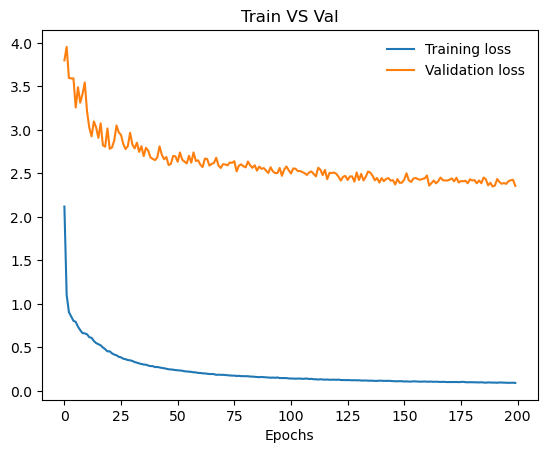

In [305]:
t = [np.mean(train_loss[el]) for el in range(len(train_loss))]
v = [np.mean(val_loss[el]) for el in range(len(val_loss))]

fig, ax = plt.subplots()
ax.plot(t, label='Training loss')
ax.plot(v, label='Validation loss')
ax.set_title(f"Train VS Val")
ax.set_xlabel("Epochs")
ax.legend(frameon=False)
plt.show()

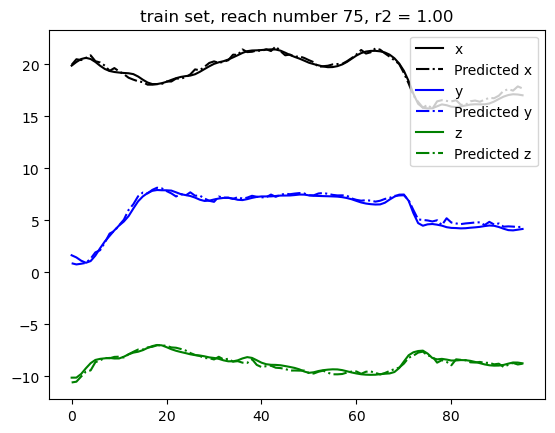

In [303]:
eval_dict = dict(group='train', idx=0, spikes=spikes_train, position=pos_train)
trial_r2 = predict_single_trial_position(lstm_model, 
                                         eval_dict, 
                                         sequence_bins, 
                                         decoder_lead_bins,
                                         spikes_t0_bin, 
                                         device, 
                                         plot=True)

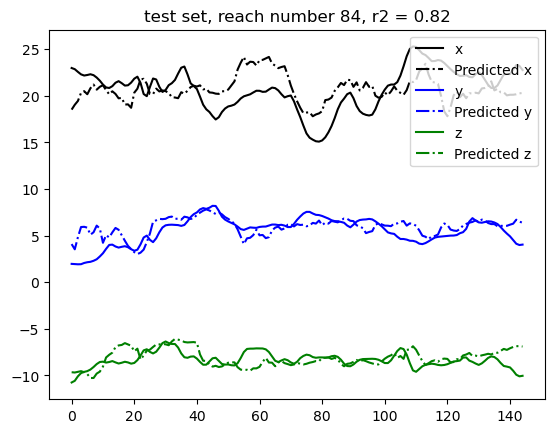

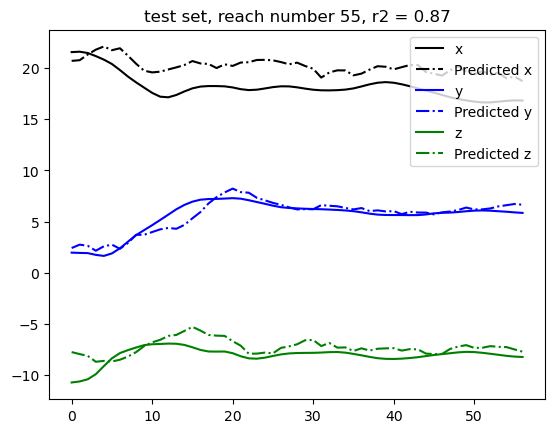

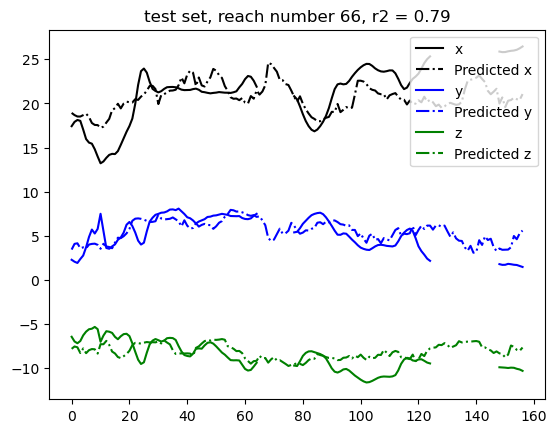

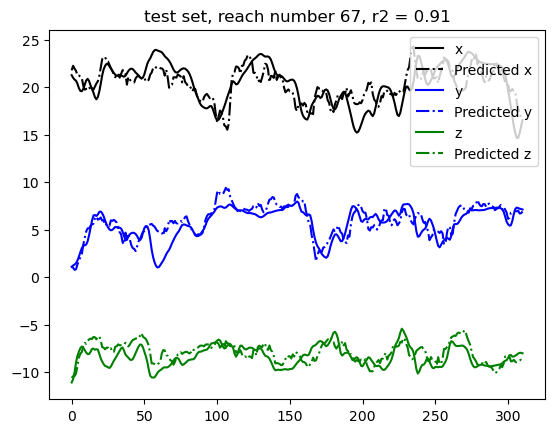

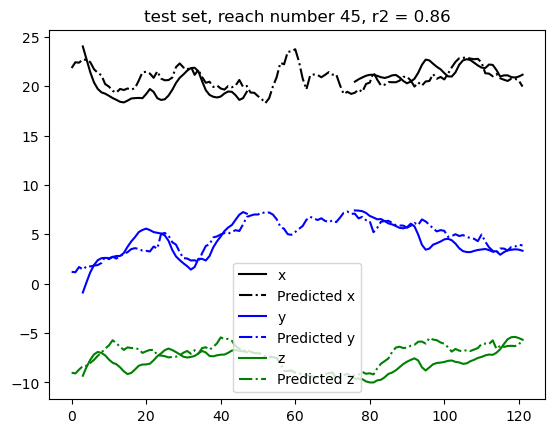

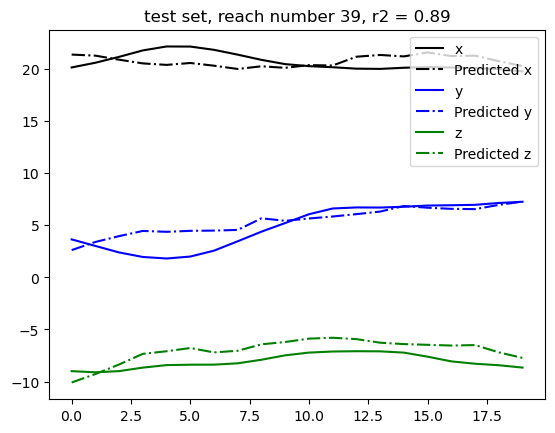

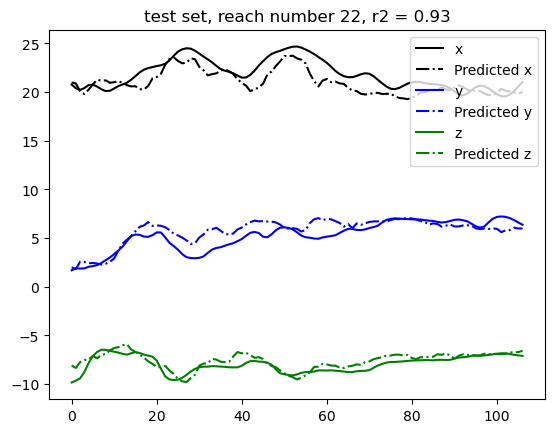

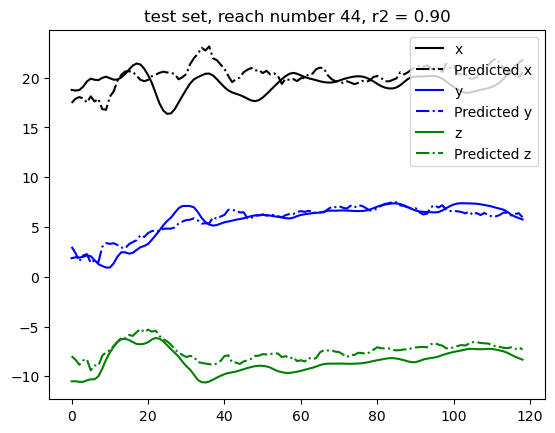

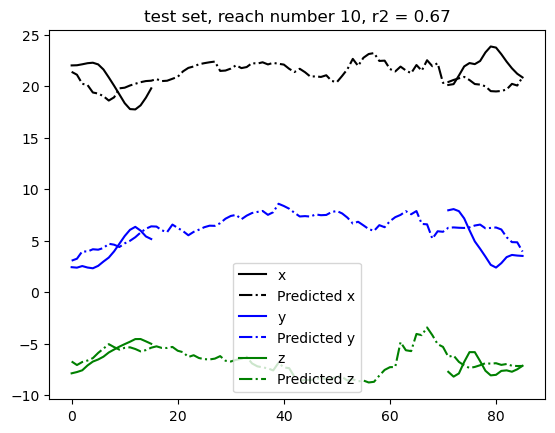

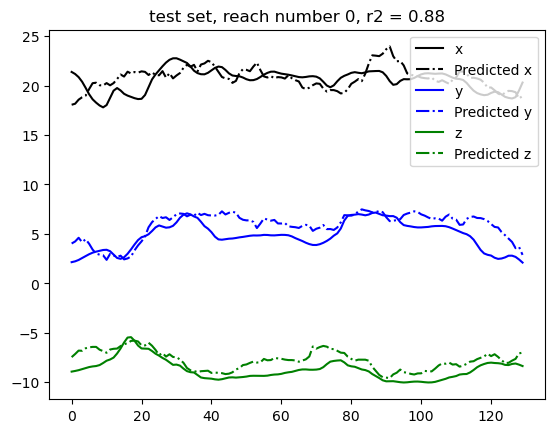

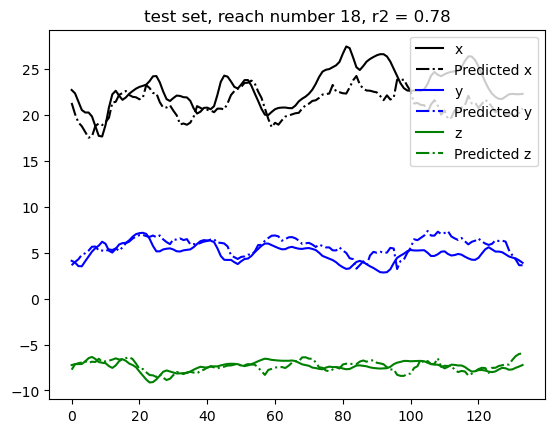

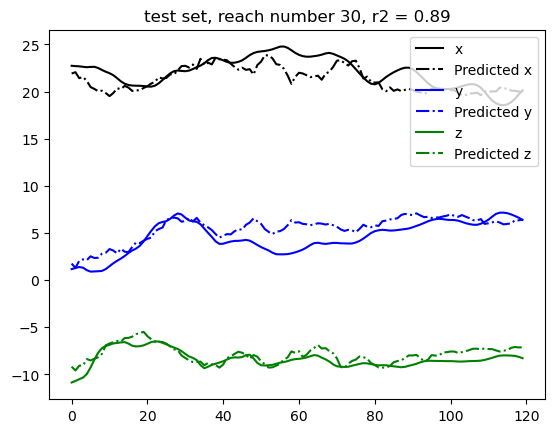

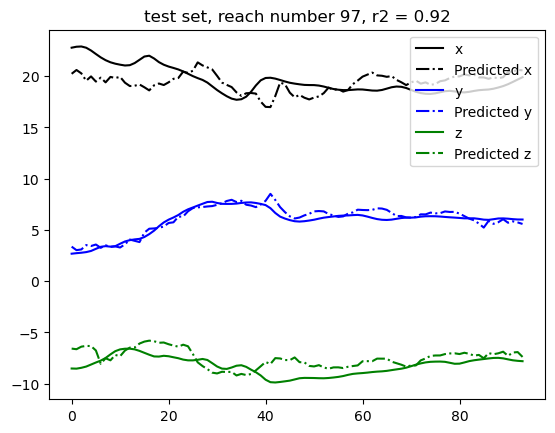

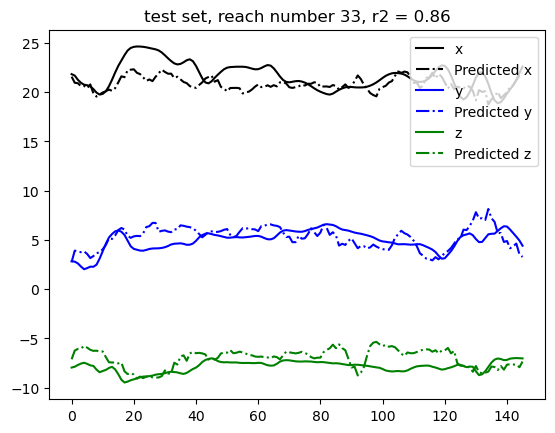

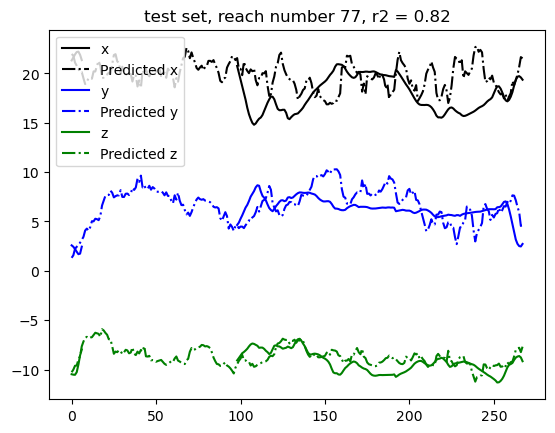

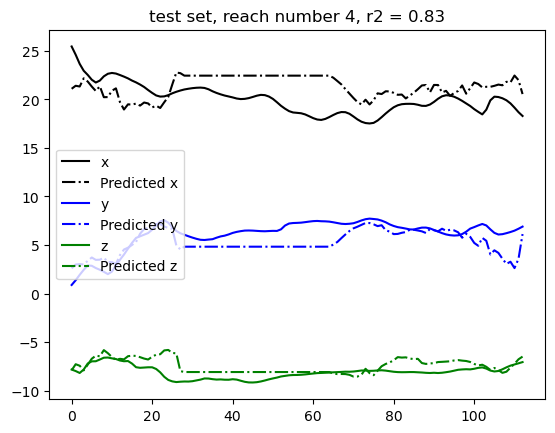

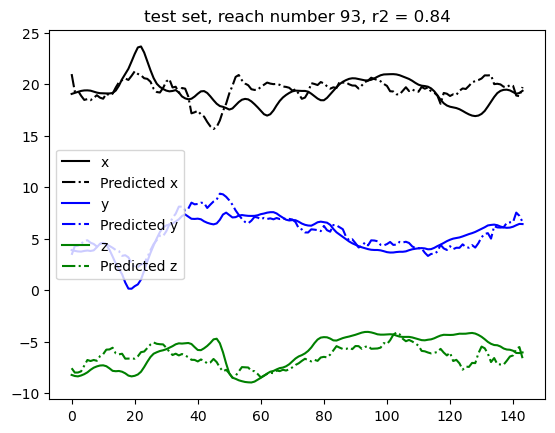

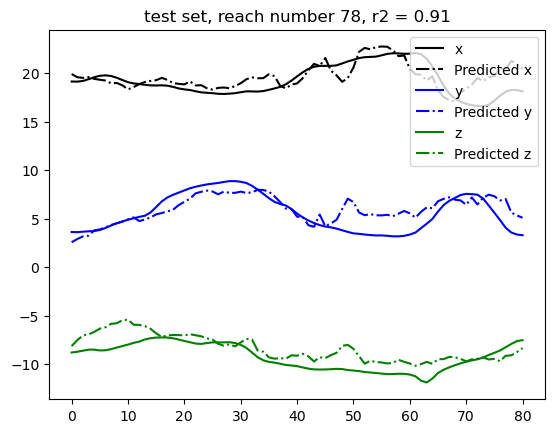

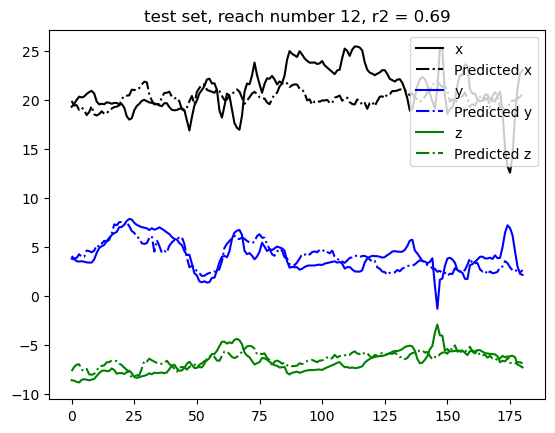

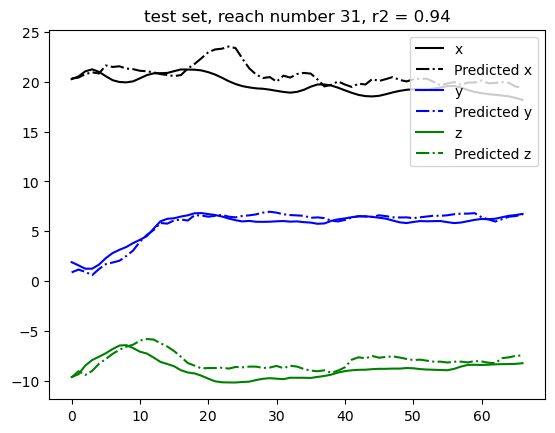

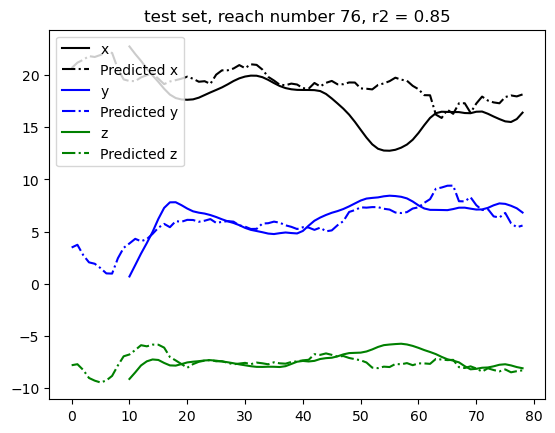

combined R2 = 0.8499922989723449


In [304]:
combined_r2 = test_set_performance(lstm_model, spikes_test, pos_test, sequence_bins, decoder_lead_bins, spikes_t0_bin, device, plot=True)
print(f'combined R2 = {combined_r2}')